Importing libraries

In [ ]:
!pip install accelerate -U

import sys
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import re
import string
import torch

from transformers import Trainer, TrainingArguments
from torch.optim import AdamW
from accelerate import Accelerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset

Load data from files into a single dataframe with 3 columns: title, text, label

In [ ]:
fakeOrRealData = pd.read_csv('drive/MyDrive/datasets/fake_or_real_news.csv');
fakeOrRealData['label'] = fakeOrRealData['label'].str.lower();

newsArticles = pd.read_csv('drive/MyDrive/datasets/news_articles.csv');
newsArticles['label'] = newsArticles['label'].str.lower();
newsArticles = newsArticles[10:] #remove first 10 articles to use for manual testing

covidNews = pd.read_csv('drive/MyDrive/datasets/COVID-19 fake news.csv');
covidNews = covidNews[10:] #remove first 10 articles to use for manual testing
covidNews['label'] = covidNews['label'].replace({0: 'fake', 1: 'real'});

covidNews2 = pd.read_csv('drive/MyDrive/datasets/corona_fake.csv');
covidNews2['label'] = covidNews2['label'].replace({'Fake': 'fake', 'TRUE': 'real'});

labeled_data = pd.concat([fakeOrRealData[['title','text', 'label']], newsArticles[['title','text', 'label']], covidNews[['title','text', 'label']], covidNews2[['title','text', 'label']]]);
labeled_data = labeled_data.dropna();
print(labeled_data.info());

<class 'pandas.core.frame.DataFrame'>
Index: 12551 entries, 0 to 1163
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   12551 non-null  object
 1   text    12551 non-null  object
 2   label   12551 non-null  object
dtypes: object(3)
memory usage: 392.2+ KB
None


Visualize the distribution of 'real' and 'fake' news

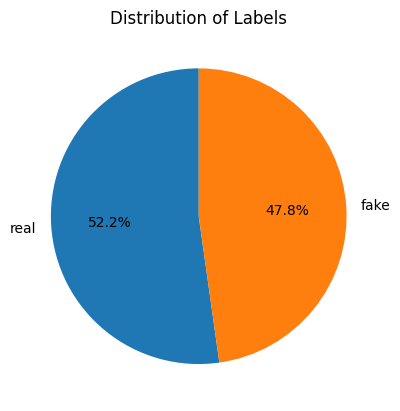

In [ ]:
#Visualize data
label_counts = labeled_data['label'].value_counts();
fig, ax = plt.subplots();
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90);
ax.set_aspect('equal');  # Equal aspect ratio so that the pie chart is circular
ax.set_title('Distribution of Labels');
plt.show();

Prepare data by processing text. Remove stopwords from the data, whitespaces, URLs, non-alphanumeric characters etc

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords');
nltk.download('punkt');

stop_words2 = set(stopwords.words('english'));

def remove_stopwords(text):
   tokens = word_tokenize(text);
   filtered_tokens = [word for word in tokens if word.lower() not in stop_words2];
   filtered_text = ' '.join(filtered_tokens);
   return filtered_text;

def process_text(text):
    text = text.lower().split();
    text = " ".join(text); #remove extra whitespaces
    text = re.sub('\n', '', text); #remove newlines
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text); #Replace any non-alphanumeric characters
    text = re.sub('https?://\S+|www\.\S+', '', text); #remove URLs
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text); #remove punctuation
    text = re.sub('\w*\d\w*', '', text); #remove words containing digits
    return text;

labeled_data_processed = labeled_data

# Remove stopwords from the 'text' column
#labeled_data_processed['text'] = labeled_data['text'].apply(remove_stopwords);
#print("Removed stopwords");
labeled_data_processed['text'] = labeled_data['text'].apply(process_text);
print("Finished processing text");

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Finished processing text


Splitting data into training and testing datasets. 80% of the total dataset will be used for training, and the remaining 20% will be used to test the performance of the model

In [ ]:
x_features = labeled_data_processed[['title', 'text']];
x_features['combined_text'] = x_features['title'] + ' ' + x_features['text'];
x = x_features['combined_text'];

y = labeled_data_processed['label'];

vectorizer = TfidfVectorizer(stop_words='english');
x_vectorized = vectorizer.fit_transform(x);

# Split the data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x_vectorized, y, test_size=0.2, random_state=30);
print('Training dataset size: ' + str(x_train.shape[0]));
print('Testing dataset size: ' + str(x_test.shape[0]));

Training dataset size: 10040
Testing dataset size: 2511



# Training models
Logistic regression model

With removed stopwords: 0.83 accuracy

Without removed stopwords: 0.83 accuracy

In [ ]:
model = LogisticRegression(max_iter=1000);
#model = SVC(kernel='linear');
#model = MultinomialNB();

# Train model
model.fit(x_train, y_train);

# Test model and stats
y_predicted = model.predict(x_test);

accuracy = accuracy_score(y_test, y_predicted);
print("Accuracy:", accuracy);

print("\nClassification Report:");
print(classification_report(y_test, y_predicted));

Accuracy: 0.8315412186379928

Classification Report:
              precision    recall  f1-score   support

        fake       0.81      0.84      0.83      1199
        real       0.85      0.82      0.84      1312

    accuracy                           0.83      2511
   macro avg       0.83      0.83      0.83      2511
weighted avg       0.83      0.83      0.83      2511



Support vector machine (SVM) model

With removed stopwords: 0.84 accuracy

Witout removed stopwords: 0.84 accuracy

In [ ]:
svm_classifier = SVC(kernel='linear');  # You can choose different kernels (e.g., 'linear', 'rbf')

# Train model
svm_classifier.fit(x_train, y_train);

# Test model and stats
y_predicted = svm_classifier.predict(x_test);

accuracy = accuracy_score(y_test, y_predicted);
print("Accuracy:", accuracy);

print("\nClassification Report:");
print(classification_report(y_test, y_predicted));

Accuracy: 0.8454798884906412

Classification Report:
              precision    recall  f1-score   support

        fake       0.84      0.84      0.84      1199
        real       0.85      0.85      0.85      1312

    accuracy                           0.85      2511
   macro avg       0.85      0.85      0.85      2511
weighted avg       0.85      0.85      0.85      2511



Multinomial Naive Bayes (MNB) model

With removed stopwords: 0.77 accuracy

Witout removed stopwords: 0.77 accuracy

In [ ]:
naive_bayes_classifier = MultinomialNB();

# Train model
naive_bayes_classifier.fit(x_train, y_train);

# Test model and stats
y_predicted = naive_bayes_classifier.predict(x_test);

accuracy = accuracy_score(y_test, y_predicted);
print("Accuracy:", accuracy);

print("\nClassification Report:");
print(classification_report(y_test, y_predicted));

Accuracy: 0.7765830346475507

Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.61      0.72      1199
        real       0.72      0.93      0.81      1312

    accuracy                           0.78      2511
   macro avg       0.81      0.77      0.77      2511
weighted avg       0.80      0.78      0.77      2511



# Predict manual input

In [ ]:
def predict_article(label_model, tfidf_vectorizer, article_title, article_text):
    combined_text = article_title + ' ' + article_text;
    vectorized_input = tfidf_vectorizer.transform([combined_text]);
    predicted_label = label_model.predict(vectorized_input);
    return predicted_label[0];

def remove_stopwords(text):
   tokens = word_tokenize(text);
   filtered_tokens = [word for word in tokens if word.lower() not in stop_words2];
   filtered_text = ' '.join(filtered_tokens);
   return filtered_text;

def process_text(text):
    text = text.lower().split();
    text = " ".join(text); #remove extra whitespaces
    text = re.sub('\n', '', text); #remove newlines
    return text;

#Input article title and text
article_title = input("Enter article title: ");
article_text = input("Enter article text: ");
#article_text = remove_stopwords(article_text);
article_text = process_text(article_text);

#maybe add processing to input, such as removing stopwords

predicted_label = predict_article(logistic_regression_model, vectorizer, article_title, article_text);
print("Logistic regression predicted label:", predicted_label);

Enter article title: dr david duke and dr slattery expose hillarys treason and why trump  duke will win
Enter article text: watch dr dukes powerful new television commercial   am  watch dr dukes new television commercial
Logistic regression predicted label: real


# Hugging transformer models
There is a lack of Hugging transformer models use

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords');
nltk.download('punkt');

stop_words2 = set(stopwords.words('english'));

def remove_stopwords(text):
   tokens = word_tokenize(text);
   filtered_tokens = [word for word in tokens if word.lower() not in stop_words2];
   filtered_text = ' '.join(filtered_tokens);
   return filtered_text;

def process_text(text):
    text = text.lower().split();
    text = " ".join(text); #remove extra whitespaces
    text = re.sub('\n', '', text); #remove newlines
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text); #Replace any non-alphanumeric characters
    text = re.sub('https?://\S+|www\.\S+', '', text); #remove URLs
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text); #remove punctuation
    text = re.sub('\w*\d\w*', '', text); #remove words containing digits
    return text;

labeled_data_processed = labeled_data

# Remove stopwords from the 'text' column
#labeled_data_processed['text'] = labeled_data_processed['text'].apply(remove_stopwords);
#print("Removed stopwords");
labeled_data_processed['text'] = labeled_data_processed['text'].apply(process_text);
print("Finished processing text");

x_features = labeled_data_processed[['title', 'text']];
x_features['combined_text'] = x_features['title'] + ' ' + x_features['text'];
x = x_features['combined_text'];

y = labeled_data_processed['label'];

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30);

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Finished processing text


BERT-base-cased model

With text processing: 0.88

With text processing and removed stopwords: 0.88

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Initialize tokenizer and model and switch to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
print("Device is " + str(device));
tokenizer = BertTokenizer.from_pretrained('bert-base-cased');
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2).to(device);

# Tokenize the input data
x_train_encodings = tokenizer(x_train.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);
x_test_encodings = tokenizer(x_test.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);

# Convert labels to integers
label_map = {'real': 0, 'fake': 1};
y_train_encoded = y_train.map(label_map);
y_test_encoded = y_test.map(label_map);

train_dataset = TensorDataset(
    x_train_encodings['input_ids'].clone().detach(),
    x_train_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_train_encoded.values).to(device)
);

test_dataset = TensorDataset(
    x_test_encodings['input_ids'].clone().detach(),
    x_test_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_test_encoded.values).to(device)
);

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True);
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False);

optimizer = AdamW(model.parameters(), lr=5e-5);

# Train the model
model.train();
for epoch in range(3):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch;
        optimizer.zero_grad();
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels);
        loss = outputs.loss;
        loss.backward();
        optimizer.step();

# Evaluate the model
model.eval();
predictions = [];
true_labels = [];
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch;
        outputs = model(input_ids=input_ids, attention_mask=attention_mask);
        logits = outputs.logits;
        predicted_labels = torch.argmax(logits, dim=1);
        predictions.extend(predicted_labels.tolist());
        true_labels.extend(labels.tolist());

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions);
print("Accuracy:", accuracy);

# Classification report
print("\nClassification Report:");
print(classification_report(true_labels, predictions));

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions);
print("Confusion Matrix:");
print(conf_matrix);

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8809239346873755

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1312
           1       0.94      0.80      0.87      1199

    accuracy                           0.88      2511
   macro avg       0.89      0.88      0.88      2511
weighted avg       0.89      0.88      0.88      2511



ALBERT-base model

With text processing and removed stopwords: 0.83

In [ ]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification

# Initialize tokenizer and model and switch to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
print("Device is " + str(device));
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2');
albert_model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2).to(device);

# Tokenize the input data
x_train_encodings = tokenizer(x_train.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);
x_test_encodings = tokenizer(x_test.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);

# Convert labels to integers
label_map = {'real': 0, 'fake': 1};
y_train_encoded = y_train.map(label_map);
y_test_encoded = y_test.map(label_map);

train_dataset = TensorDataset(
    x_train_encodings['input_ids'].clone().detach(),
    x_train_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_train_encoded.values).to(device)
);

test_dataset = TensorDataset(
    x_test_encodings['input_ids'].clone().detach(),
    x_test_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_test_encoded.values).to(device)
);

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True);
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False);

optimizer = AdamW(albert_model.parameters(), lr=5e-5);

# Train the model
albert_model.train();
for epoch in range(3):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch;
        optimizer.zero_grad();
        outputs = albert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels);
        loss = outputs.loss;
        loss.backward();
        optimizer.step();

# Evaluate the model
albert_model.eval();
predictions = [];
true_labels = [];
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch;
        outputs = albert_model(input_ids=input_ids, attention_mask=attention_mask);
        logits = outputs.logits;
        predicted_labels = torch.argmax(logits, dim=1);
        predictions.extend(predicted_labels.tolist());
        true_labels.extend(labels.tolist());

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions);
print("Accuracy:", accuracy);

# Classification report
print("\nClassification Report:");
print(classification_report(true_labels, predictions));

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions);
print("Confusion Matrix:");
print(conf_matrix);

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8375149342891278

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      1312
           1       0.78      0.91      0.84      1199

    accuracy                           0.84      2511
   macro avg       0.84      0.84      0.84      2511
weighted avg       0.85      0.84      0.84      2511



RoBERTa model

Took 13 min

With and removing stopwords text processing: 0.90 (roberta-base)



In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Initialize tokenizer and model and switch to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
print("Device is " + str(device));
tokenizer = RobertaTokenizer.from_pretrained('roberta-base');
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2).to(device);

# Tokenize the input data
x_train_encodings = tokenizer(x_train.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);
x_test_encodings = tokenizer(x_test.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);

# Convert labels to integers
label_map = {'real': 0, 'fake': 1};
y_train_encoded = y_train.map(label_map);
y_test_encoded = y_test.map(label_map);

train_dataset = TensorDataset(
    x_train_encodings['input_ids'].clone().detach(),
    x_train_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_train_encoded.values).to(device)
);

test_dataset = TensorDataset(
    x_test_encodings['input_ids'].clone().detach(),
    x_test_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_test_encoded.values).to(device)
);

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

optimizer = AdamW(roberta_model.parameters(), lr=5e-5);

# Train the model
roberta_model.train();
for epoch in range(3):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch;
        optimizer.zero_grad();
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels);
        loss = outputs.loss
        loss.backward();
        optimizer.step();

# Evaluate the model
roberta_model.eval();
predictions = [];
true_labels = [];
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch;
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask);
        logits = outputs.logits;
        predicted_labels = torch.argmax(logits, dim=1);
        predictions.extend(predicted_labels.tolist());
        true_labels.extend(labels.tolist());

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions);
print("Accuracy:", accuracy);

# Classification report
print("\nClassification Report:");
print(classification_report(true_labels, predictions));

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions);
print("Confusion Matrix:");
print(conf_matrix);

Device is cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.9040223018717642

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1312
           1       0.93      0.86      0.90      1199

    accuracy                           0.90      2511
   macro avg       0.91      0.90      0.90      2511
weighted avg       0.91      0.90      0.90      2511

Confusion Matrix:
[[1236   76]
 [ 165 1034]]


Save trained Roberta model

In [ ]:
roberta_model.save_pretrained("drive/MyDrive/models/robertaArticles/");
tokenizer.save_pretrained("drive/MyDrive/models/robertaArticles/");

Load trained Roberta model

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
loaded_model = RobertaForSequenceClassification.from_pretrained("drive/MyDrive/models/robertaArticles/").to(device);
loaded_tokenizer = RobertaTokenizer.from_pretrained("drive/MyDrive/models/robertaArticles/");

Test loaded model performance

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
print("Device is " + str(device));

# Tokenize the input data
x_test_encodings = loaded_tokenizer(x_test.tolist(), truncation=True, padding=True, return_tensors='pt').to(device);

# Convert labels to integers
label_map = {'real': 0, 'fake': 1};
y_test_encoded = y_test.map(label_map);

test_dataset = TensorDataset(
    x_test_encodings['input_ids'].clone().detach(),
    x_test_encodings['attention_mask'].clone().detach(),
    torch.tensor(y_test_encoded.values).to(device)
);

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False);

# Evaluate the model
loaded_model.eval();
predictions = [];
true_labels = [];
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch;
        outputs = loaded_model(input_ids=input_ids, attention_mask=attention_mask);
        logits = outputs.logits;
        predicted_labels = torch.argmax(logits, dim=1);
        predictions.extend(predicted_labels.tolist());
        true_labels.extend(labels.tolist());

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions);
print("Accuracy:", accuracy);

# Classification report
print("\nClassification Report:");
print(classification_report(true_labels, predictions));

conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Device is cuda
Accuracy: 0.9040223018717642

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1312
           1       0.93      0.86      0.90      1199

    accuracy                           0.90      2511
   macro avg       0.91      0.90      0.90      2511
weighted avg       0.91      0.90      0.90      2511

Confusion Matrix:
[[1236   76]
 [ 165 1034]]


# Graphs

Some graphs to better visualise data

In [ ]:
fakeOrRealData = pd.read_csv('drive/MyDrive/datasets/fake_or_real_news.csv');
fakeOrRealData['label'] = fakeOrRealData['label'].str.lower();
fakeOrRealData = fakeOrRealData.dropna();
fakeOrRealData = fakeOrRealData.head(2000);


newsArticles = pd.read_csv('drive/MyDrive/datasets/news_articles.csv');
newsArticles['label'] = newsArticles['label'].str.lower();
newsArticles = newsArticles.dropna();
newsArticles = newsArticles.head(2000);

covidNews = pd.read_csv('drive/MyDrive/datasets/COVID-19 fake news.csv');
covidNews = covidNews[10:] #remove first 10 articles to use for manual testing
covidNews['label'] = covidNews['label'].replace({0: 'fake', 1: 'real'});
covidNews = covidNews.dropna();
covidNews = covidNews.head(3000);

covidNews2 = pd.read_csv('drive/MyDrive/datasets/corona_fake.csv');
covidNews2['label'] = covidNews2['label'].replace({'Fake': 'fake', 'TRUE': 'real'});
covidNews2 = covidNews2.dropna();
covidNews2 = covidNews2.head(1000);

labeled_data = pd.concat([fakeOrRealData[['title','text', 'label']], newsArticles[['title','text', 'label']], covidNews[['title','text', 'label']], covidNews2[['title','text', 'label']]]);
labeled_data = labeled_data.dropna();
print(labeled_data.info());

fake_data = labeled_data[labeled_data['label'] == 'fake']

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 0 to 1104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8000 non-null   object
 1   text    8000 non-null   object
 2   label   8000 non-null   object
dtypes: object(3)
memory usage: 250.0+ KB
None


In [ ]:
#Remove stopwords for most frequently used words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords');
nltk.download('punkt');

stop_words2 = set(stopwords.words('english'));

def remove_stopwords(text):
   tokens = word_tokenize(text);
   filtered_tokens = [word for word in tokens if word.lower() not in stop_words2];
   filtered_text = ' '.join(filtered_tokens);
   return filtered_text;

# Remove stopwords from the 'text' column
fake_data_no_stopwords = fake_data;
fake_data_no_stopwords['text'] = fake_data_no_stopwords['text'].apply(remove_stopwords);

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-4-0880ebc000d7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_data_no_stopwords['text'] = fake_data_no_stopwords['text'].apply(remove_stopwords);


Functions used to get the frequency of words and group of words

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus);
    bag_of_words = vec.transform(corpus);
    sum_words = bag_of_words.sum(axis=0);
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()];
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True);
    return words_freq[:n];

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus);
    bag_of_words = vec.transform(corpus);
    sum_words = bag_of_words.sum(axis=0);
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()];
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True);
    return words_freq[:n];


def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus);
    bag_of_words = vec.transform(corpus);
    sum_words = bag_of_words.sum(axis=0);
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()];
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True);
    return words_freq[:n];



Get the most frequently used words and plot the result


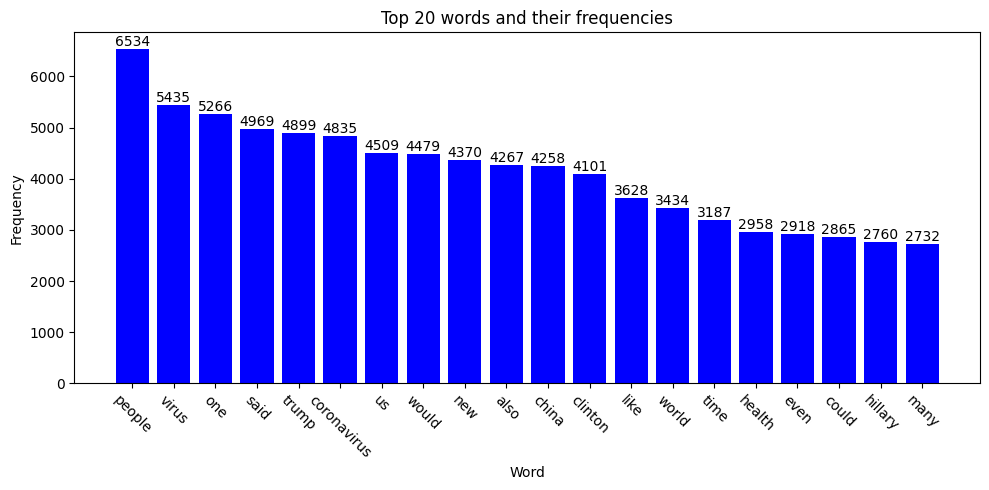

In [ ]:
common_words = get_top_n_words(fake_data_no_stopwords['text'], 20);
#also get equal numer of articles for each subject (us politics, covid) (1000 articles only)

df_common_words = DataFrame(common_words,columns=['word','count']);
df_common_words = df_common_words.sort_values(by='count', ascending=False);

# Plot the top 20 words
n = 20;
plt.figure(figsize=(10, 5));
bars = plt.bar(df_common_words['word'][:n], df_common_words['count'][:n], color='blue');

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.xlabel('Word');
plt.ylabel('Frequency');
plt.title('Top {} words and their frequencies'.format(n));
plt.xticks(rotation=-45);  # Rotate x-axis labels for better readability
plt.tight_layout();
plt.show();

Get the most frequently used groups of 2 words and plot the result

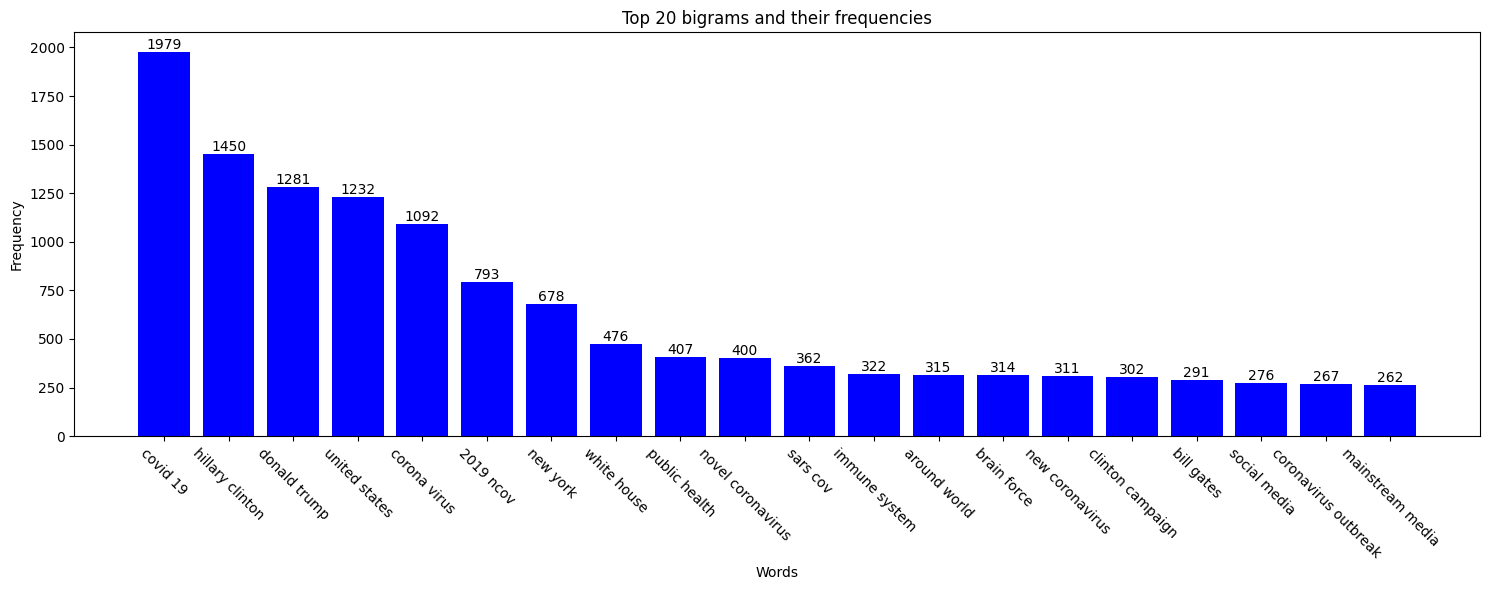

In [ ]:
common_bigrams = get_top_n_bigram(fake_data['text'], 20);
df_common_bigrams = DataFrame(common_bigrams, columns = ['words' ,'count']);

# Plot the top 20 bigrams
n = 20;
plt.figure(figsize=(15, 6));
bars = plt.bar(df_common_bigrams['words'][:n], df_common_bigrams['count'][:n], color='blue');

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.xlabel('Words');
plt.ylabel('Frequency');
plt.title('Top {} bigrams and their frequencies'.format(n));
plt.xticks(rotation=-45);  # Rotate x-axis labels for better readability
plt.tight_layout();
plt.show();

Get the most frequently used groups of 3 words and plot the result


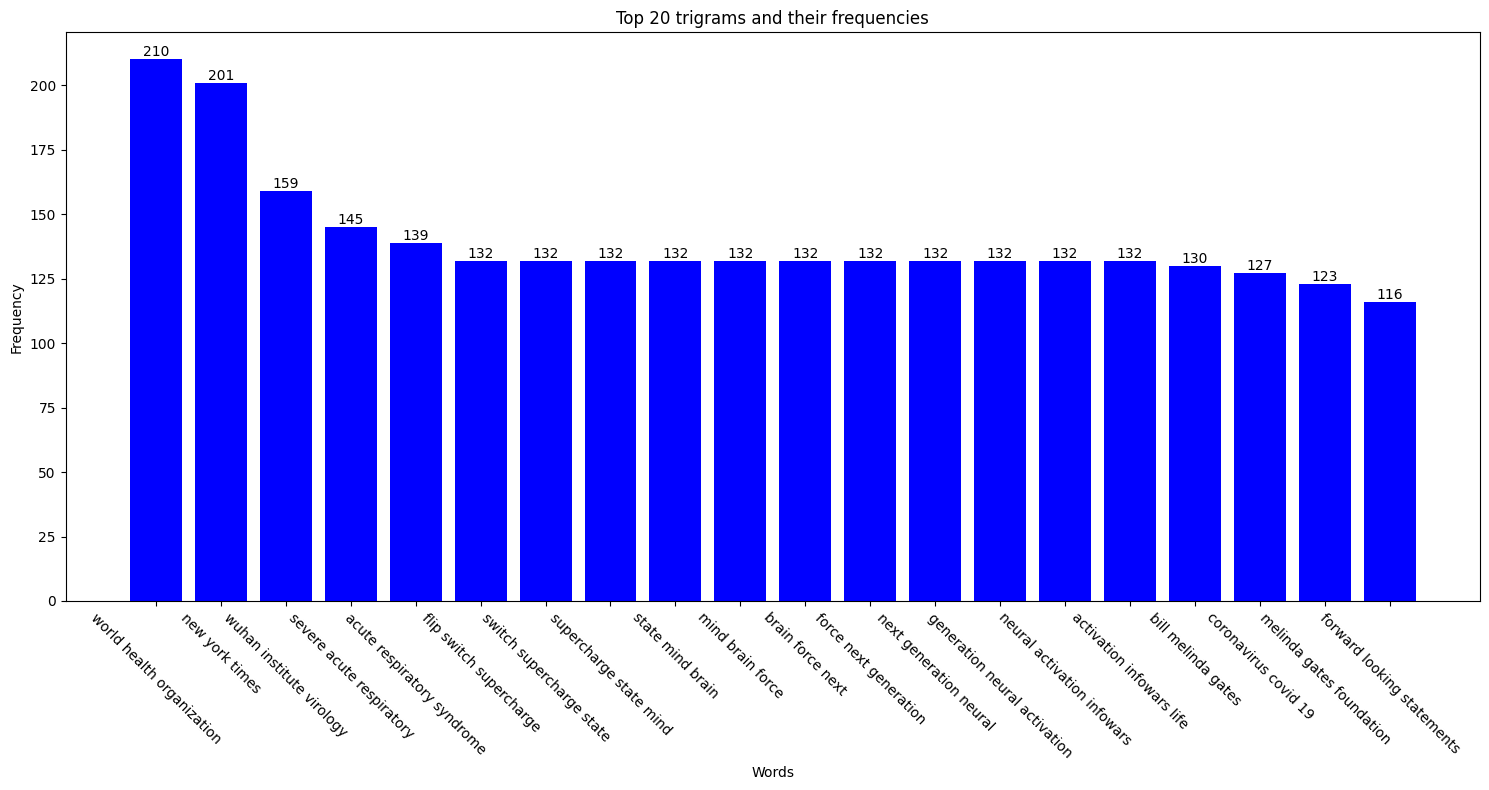

In [ ]:
common_trigrams = get_top_n_trigram(fake_data['text'], 20);
df_common_trigrams = DataFrame(common_trigrams, columns = ['words' ,'count']);

# Plot the top 20 trigrams
n = 20;
plt.figure(figsize=(15, 8));
bars = plt.bar(df_common_trigrams['words'][:n], df_common_trigrams['count'][:n], color='blue');

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.xlabel('Words');
plt.ylabel('Frequency');
plt.title('Top {} trigrams and their frequencies'.format(n));
plt.xticks(rotation=-45)  # Rotate x-axis labels for better readability
plt.tight_layout();
plt.show();